# Logistic regression

# First we'll do logistic regression with Keras

In [1]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from collections import defaultdict
import random
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  
random.seed(15)
%matplotlib inline

Using TensorFlow backend.


In [2]:
#read in the labels and filenames
data_csv = pd.read_csv('train.csv')

In [3]:
#check out the distribution of the data labels to see if we should evaluate precision/recall instead of accuracy 
#it seems reasonable to proceed with accuracy since there is a significant proportion of 1's and 0's
data_csv['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [4]:
#get size of images and number of images
img = load_img('./train/'+data_csv.loc[1]['id'])
img_array = img_to_array(img)
n_h, n_w, n_c = img_array.shape
m = data_csv.shape[0]
print('Image size:', n_h, n_w, n_c)
print('Number of images:',data_csv.shape[0])

Image size: 32 32 3
Number of images: 17500


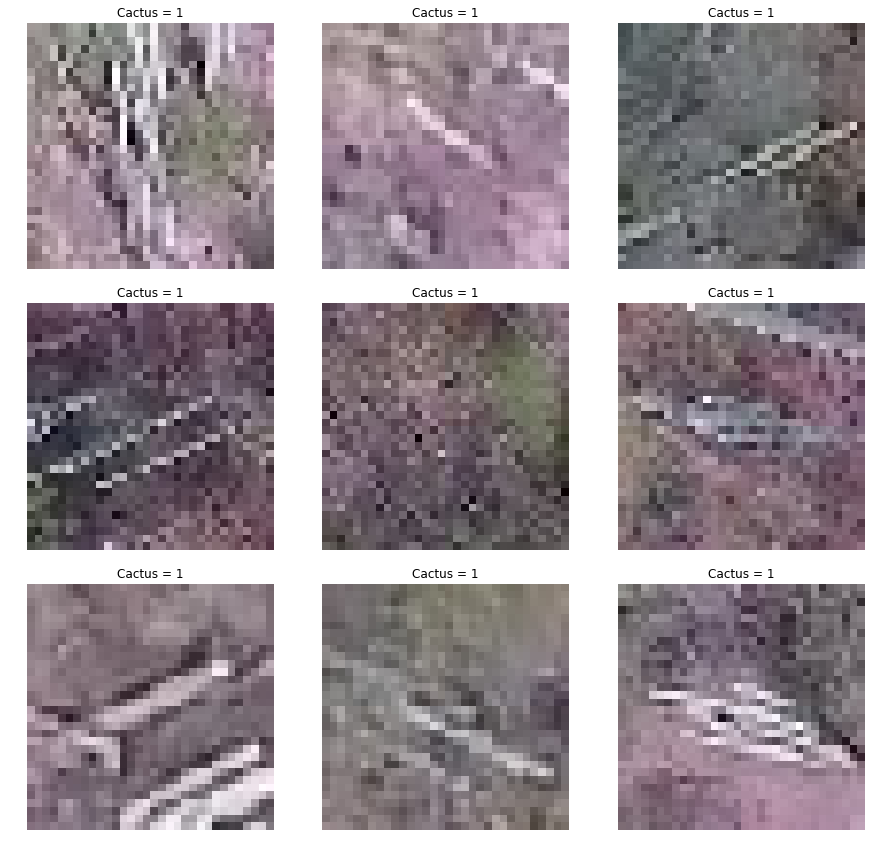

In [5]:
#let's look at the dataset and see what a cactus looks like from an aerial view :)
plt.figure(figsize=(15, 15))
for i in range(1,10,1):
    pic_number = random.randrange(1,17500)
    img = load_img('./train/'+data_csv.loc[pic_number]['id'])
    title = 'Cactus = ' + str(data_csv.loc[pic_number]['has_cactus'])

    curr_plot = int("33" + str(i))
    plt.subplot(curr_plot)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
plt.subplots_adjust(hspace=0.1)
plt.show()

In [6]:
#initialize arrays to hold the image data
full_data = np.zeros((m, n_h, n_w, n_c))
full_labels = np.zeros((m,1))


In [7]:
#load data into arrays
for i, row in data_csv.iterrows():
    img = load_img('./train/'+row.id)
    full_data[i,:,:,:] = img_to_array(img)/255 # load into numpy array and normalize
    full_labels[i] = row.has_cactus # load into numpy array

In [8]:
#split data into 90/10 train/dev sets 
X_train, X_dev, Y_train, Y_dev = train_test_split(full_data, full_labels, test_size=0.1, random_state=42)

In [9]:
#check array sizes make sense
print(X_train.shape, X_dev.shape, Y_train.shape, Y_dev.shape)

(15750, 32, 32, 3) (1750, 32, 32, 3) (15750, 1) (1750, 1)


In [10]:
#now we'll build a keras model
def make_cactus_model(input_shape):

    X_input = Input(input_shape)


    X = Flatten()(X_input)
    
    #Single fully conncected sigmoid layer for is same as logistic regression
    X = Dense(1, activation='sigmoid', name='fc_2')(X)

    #Make the model
    model = Model(inputs = X_input, outputs = X, name='make_cactus_model')
    
    return model

In [11]:
#define precision, recall, f1 courtesy of Tasos: datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
#initialize the model
cactus_model = make_cactus_model((n_h,n_w,n_c))

In [13]:
#Use adam optimization algorithm with 'binary_crossentropy' or log loss since it's a binary classification, and accuracy metric
cactus_model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy", precision_m, recall_m, f1_m])

In [14]:
#Run the model for 20 epochs and check the dev set after each epoch
for i in range(20):
    cactus_model.fit(x =X_train, y =Y_train, epochs = 1, batch_size = 64)
    preds = cactus_model.evaluate(x = X_dev, y = Y_dev)
    print ("Test Loss = " + str(preds[0])+"Accuracy = " + str(preds[1]))
    print()

Epoch 1/1
1750/1750 [==============================] - 0s 166us/step
Test Loss = 0.47370100484575545Accuracy = 0.7708571431296213

Epoch 1/1
1750/1750 [==============================] - 0s 40us/step
Test Loss = 0.43569313785008024Accuracy = 0.7794285717010498

Epoch 1/1
1750/1750 [==============================] - 0s 37us/step
Test Loss = 0.3948586484364101Accuracy = 0.8194285717010498

Epoch 1/1
1750/1750 [==============================] - 0s 36us/step
Test Loss = 0.39780444029399326Accuracy = 0.8342857140132359

Epoch 1/1
1750/1750 [==============================] - 0s 34us/step
Test Loss = 0.37306164857319424Accuracy = 0.8200000000681196

Epoch 1/1
1750/1750 [==============================] - 0s 37us/step
Test Loss = 0.3745572773047856Accuracy = 0.8079999998637608

Epoch 1/1
1750/1750 [==============================] - 0s 33us/step
Test Loss = 0.36851135761397225Accuracy = 0.8131428570066179

Epoch 1/1
1750/1750 [==============================] - 0s 34us/step
Test Loss = 0.363710749

In [15]:
preds = cactus_model.evaluate(x = X_dev, y = Y_dev)
print ("Test Loss = " + str(round(preds[0],3))+" Accuracy = " + str(round(preds[1],3)), " Precision = " + str(round(preds[2],3)),
        " Recall = " + str(round(preds[3],3)),  " F1 score = " + str(round(preds[4],3)))

1750/1750 [==============================] - 0s 48us/step
Test Loss = 0.366 Accuracy = 0.808  Precision = 0.82  Recall = 0.954  F1 score = 0.879


In [16]:
# a summary of the model
print(cactus_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
fc_2 (Dense)                 (None, 1)                 3073      
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None


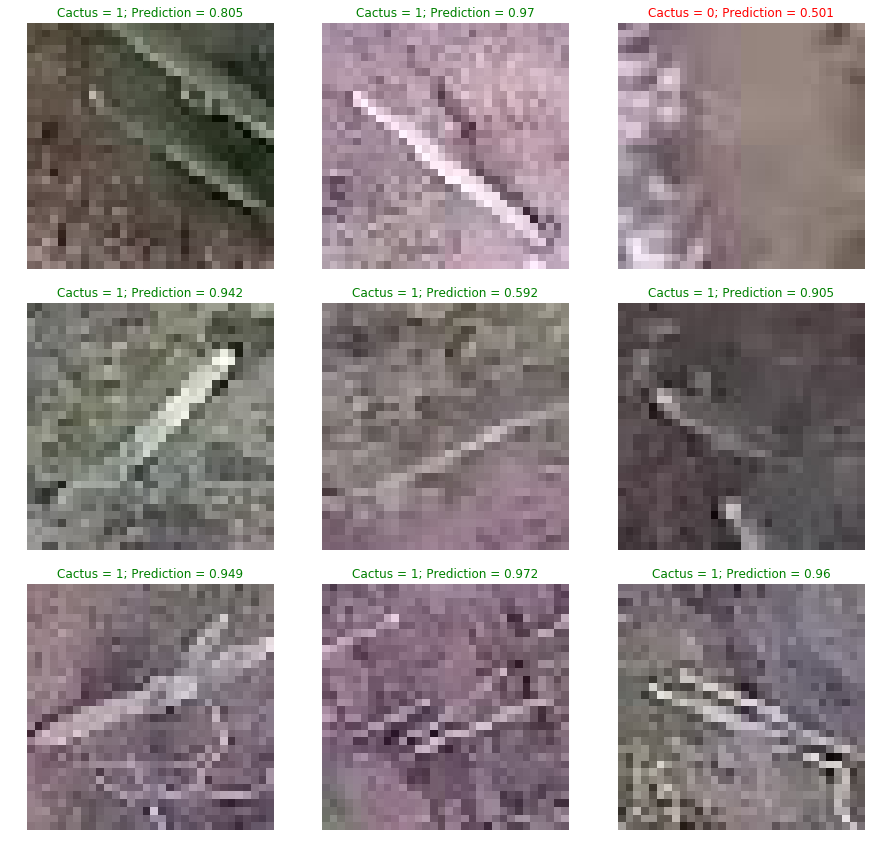

In [17]:
# let's see some predictions from the dev set
plt.figure(figsize=(15, 15))
for i in range(1,10,1):
    pic_number = random.randrange(1,X_dev.shape[0])
    prediction = round(float(cactus_model.predict(X_dev[pic_number:pic_number+1,:,:,:])),3)
    title = 'Cactus = ' + str(int(Y_dev[pic_number])) + "; Prediction = " + str(prediction)
    curr_plot = int("33" + str(i))
    plt.subplot(curr_plot)
    plt.imshow(X_dev[pic_number,:,:,:])
    title_obj = plt.title(title)
    plt.axis('off')
    if abs(float(Y_dev[pic_number])-prediction) > 0.5:
        plt.setp(title_obj, color='r')
    else:
        plt.setp(title_obj, color='g')
plt.subplots_adjust(hspace=0.1)
plt.show()

### Now let's try scikit-learn to confirm we get a similar result and also do a 10-fold cross validation for comparison with the CNN

In [18]:
#flatten the images
X_skl = np.reshape(full_data,(full_data.shape[0],-1))
Y_skl = np.reshape(full_labels,(full_labels.shape[0]))




In [19]:
metric_dict = defaultdict(list)
#10-fold cross validation
kfold = KFold(10, True, 1)
for k, (train, test) in enumerate(kfold.split(X_skl)):
    curr_train_X = X_skl[train]
    curr_train_Y = Y_skl[train]
    curr_test_X = X_skl[test]
    curr_test_Y = Y_skl[test]
    clf = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial',max_iter=1000).fit(curr_train_X,  curr_train_Y)
    test_acc = clf.score(curr_test_X, curr_test_Y)
    y_pred = clf.predict(curr_test_X)
    test_prec, test_recall, f1_score, _ = precision_recall_fscore_support(curr_test_Y, y_pred)
    metric_dict["test_acc"].append(float(test_acc))
    metric_dict["test_recall"].append(test_recall[1])
    metric_dict["test_prec"].append(test_prec[1])
    metric_dict["f1_score"].append(f1_score[1])

In [20]:
#finally examine the results of 10-fold CV in terms of the different metrics
metric_df = pd.DataFrame(metric_dict)
metric_df.describe()

,test_acc,test_recall,test_prec,f1_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.900800,0.926520,0.940456,0.933412
std,0.006421,0.006310,0.007300,0.004599
min,0.889714,0.912943,0.926979,0.924698
25%,0.898143,0.926988,0.936790,0.931995
50%,0.902286,0.928463,0.941655,0.934230
75%,0.905286,0.930314,0.945248,0.936505
max,0.908571,0.932382,0.951296,0.939084


The evaluation metrics are lower for logistic regression than for the CNN. It is worth noting that logistic regression is still doing better than 0.9 F1 score, which is pretty descent considering the simplicity of the model. 